#Import the libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take, delete
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

#Get the data

In [2]:
#read raw text file

def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
# split a text into sentences

def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    
    return sents

In [4]:
#read the text data and convert into sentencce

data = read_text("/content/drive/MyDrive/Colab Notebooks/natural language processing/Neural Machine Translation/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
        'Wenn jemand Fremdes dir sagt, dass du dich wie ein Muttersprachler anhörst, bedeutet das wahrscheinlich: Er hat etwas an deinem Sprechen bemerkt, dass dich als Nicht-Muttersprachler verraten hat. Mit anderen Worten: Du hörst dich nicht wirklich wie ein Muttersprachler an.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #953936 (CK) & #3807493 

In [6]:
deu_eng = deu_eng[:45000,:] # using only right amount of data as per computer's computation power

#Text Preprocessing

In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom is looking at me.', 'Tom sieht mich an.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1868192 (CK) & #2133426 (Pfirsichbaeumchen)'],
       ['Tom is looking at us.', 'Tom sieht uns an.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547579 (CK) & #6642305 (Felixjp)'],
       ['Tom is looking tired.', 'Tom sieht müde aus.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5148117 (CK) & #1937999 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [8]:
deu_english = delete(deu_eng, 2, 1)

In [9]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_english[i,0] = deu_english[i,0].lower()
    
    deu_english[i,1] = deu_english[i,1].lower()

In [10]:
deu_english

array([['go.', 'geh.'],
       ['hi.', 'hallo!'],
       ['hi.', 'grüß gott!'],
       ...,
       ['tom is looking at me.', 'tom sieht mich an.'],
       ['tom is looking at us.', 'tom sieht uns an.'],
       ['tom is looking tired.', 'tom sieht müde aus.']], dtype='<U537')

In [11]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_english[:,0]:
    eng_l.append(len(i.split()))

for i in deu_english[:,1]:
    deu_l.append(len(i.split()))

In [12]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

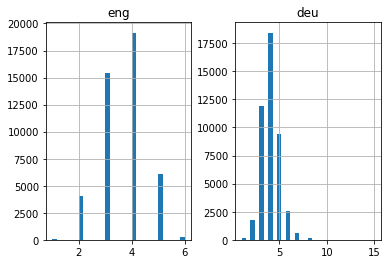

In [13]:
length_df.hist(bins = 30)
plt.show()

In [14]:
# build a tokenizer

def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [19]:
deu_eng[:,0]

array(['Go.', 'Hi.', 'Hi.', ..., 'Tom is looking at me.',
       'Tom is looking at us.', 'Tom is looking tired.'], dtype='<U537')

In [20]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 5925


In [25]:

# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 9702


In [28]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

#Train a model

In [29]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)


# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])


# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
def build_model(input_vocab,output_vocab, input_length,output_length,units):
      model = Sequential()
      model.add(Embedding(input_vocab, units, input_length=input_length, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(output_length))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(output_vocab, activation='softmax'))
      return model

In [ ]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001) # using RMSProp optimizer
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy') #to use the target sequence as it is instead of one hot encoded format

In [ ]:
#using ModelCheckpoint() to save the best model with lowest validation loss

filename = 'model.parameters'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
57/57 [==============================] - 233s 4s/step - loss: 4.3766 - val_loss: 2.8204

Epoch 00001: val_loss improved from inf to 2.82036, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 2/30
57/57 [==============================] - 226s 4s/step - loss: 2.7453 - val_loss: 2.7053

Epoch 00002: val_loss improved from 2.82036 to 2.70525, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 3/30
57/57 [==============================] - 229s 4s/step - loss: 2.6216 - val_loss: 2.5707

Epoch 00003: val_loss improved from 2.70525 to 2.57071, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 4/30
57/57 [==============================] - 229s 4s/step - loss: 2.4346 - val_loss: 2.4120

Epoch 00004: val_loss improved from 2.57071 to 2.41200, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 5/30
57/57 [==============================] - 227s 4s/step - loss: 2.2838 - val_loss: 2.3124

Epoch 00005: val_loss improved from 2.41200 to 2.31238, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 6/30
57/57 [==============================] - 227s 4s/step - loss: 2.1450 - val_loss: 2.2054

Epoch 00006: val_loss improved from 2.31238 to 2.20545, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 7/30
57/57 [==============================] - 226s 4s/step - loss: 2.0280 - val_loss: 2.1463

Epoch 00007: val_loss improved from 2.20545 to 2.14629, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 8/30
57/57 [==============================] - 226s 4s/step - loss: 1.9033 - val_loss: 2.0392

Epoch 00008: val_loss improved from 2.14629 to 2.03916, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 9/30
57/57 [==============================] - 227s 4s/step - loss: 1.8009 - val_loss: 1.9856

Epoch 00009: val_loss improved from 2.03916 to 1.98558, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 10/30
57/57 [==============================] - 226s 4s/step - loss: 1.7097 - val_loss: 1.9293

Epoch 00010: val_loss improved from 1.98558 to 1.92927, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 11/30
57/57 [==============================] - 226s 4s/step - loss: 1.6195 - val_loss: 1.8735

Epoch 00011: val_loss improved from 1.92927 to 1.87345, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 12/30
57/57 [==============================] - 226s 4s/step - loss: 1.5259 - val_loss: 1.7934

Epoch 00012: val_loss improved from 1.87345 to 1.79345, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 13/30
57/57 [==============================] - 225s 4s/step - loss: 1.4384 - val_loss: 1.7756

Epoch 00013: val_loss improved from 1.79345 to 1.77559, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 14/30
57/57 [==============================] - 226s 4s/step - loss: 1.3586 - val_loss: 1.7341

Epoch 00014: val_loss improved from 1.77559 to 1.73407, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 15/30
57/57 [==============================] - 227s 4s/step - loss: 1.2802 - val_loss: 1.6851

Epoch 00015: val_loss improved from 1.73407 to 1.68507, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 16/30
57/57 [==============================] - 224s 4s/step - loss: 1.1976 - val_loss: 1.6457

Epoch 00016: val_loss improved from 1.68507 to 1.64565, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 17/30
57/57 [==============================] - 225s 4s/step - loss: 1.1305 - val_loss: 1.6073

Epoch 00017: val_loss improved from 1.64565 to 1.60729, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 18/30
57/57 [==============================] - 227s 4s/step - loss: 1.0587 - val_loss: 1.5752

Epoch 00018: val_loss improved from 1.60729 to 1.57516, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 19/30
57/57 [==============================] - 227s 4s/step - loss: 0.9971 - val_loss: 1.5410

Epoch 00019: val_loss improved from 1.57516 to 1.54104, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 20/30
57/57 [==============================] - 226s 4s/step - loss: 0.9303 - val_loss: 1.5112

Epoch 00020: val_loss improved from 1.54104 to 1.51121, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 21/30
57/57 [==============================] - 227s 4s/step - loss: 0.8774 - val_loss: 1.4877

Epoch 00021: val_loss improved from 1.51121 to 1.48766, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 22/30
57/57 [==============================] - 227s 4s/step - loss: 0.8151 - val_loss: 1.4595

Epoch 00022: val_loss improved from 1.48766 to 1.45946, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 23/30
57/57 [==============================] - 228s 4s/step - loss: 0.7542 - val_loss: 1.4413

Epoch 00023: val_loss improved from 1.45946 to 1.44129, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 24/30
57/57 [==============================] - 226s 4s/step - loss: 0.7085 - val_loss: 1.4318

Epoch 00024: val_loss improved from 1.44129 to 1.43176, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 25/30
57/57 [==============================] - 224s 4s/step - loss: 0.6549 - val_loss: 1.4121

Epoch 00025: val_loss improved from 1.43176 to 1.41210, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 26/30
57/57 [==============================] - 224s 4s/step - loss: 0.6040 - val_loss: 1.3899

Epoch 00026: val_loss improved from 1.41210 to 1.38989, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 27/30
57/57 [==============================] - 223s 4s/step - loss: 0.5621 - val_loss: 1.3961

Epoch 00027: val_loss did not improve from 1.38989
Epoch 28/30
57/57 [==============================] - 224s 4s/step - loss: 0.5179 - val_loss: 1.3601

Epoch 00028: val_loss improved from 1.38989 to 1.36010, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 29/30
57/57 [==============================] - 223s 4s/step - loss: 0.4792 - val_loss: 1.3534

Epoch 00029: val_loss improved from 1.36010 to 1.35343, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 30/30
57/57 [==============================] - 224s 4s/step - loss: 0.4424 - val_loss: 1.3511

Epoch 00030: val_loss improved from 1.35343 to 1.35111, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


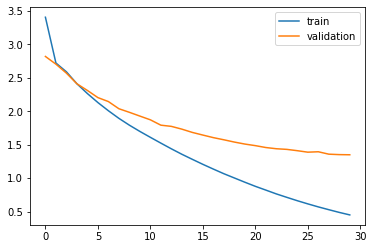

In [ ]:
#compare the training loss and the validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

#load the model and make predictions

In [49]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/natural language processing/Neural Machine Translation/model_parameters')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [99]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [100]:
# convert predictions into text (English)
preds_text = []
for i in pred:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
0,I want to resign.,i want to
1,We're surprised.,we're surprised
2,You can't deny that.,you can't buy that
3,Tell me how you feel.,tell what i you
4,Maybe it will snow.,it may snow
5,I saw somebody.,i saw it
6,Boys are not welcome.,hey don't be
7,She is traveling now.,they're is
8,He wants an iPad 4.,he wants an d
9,The woman is reading.,the cat is brown


#Summary
The prediction of our model can be seen on the right column. Model has been quite good, however, some results are not appropriate. It can be improved by training more epochs.
- I will try to train using BERT to improve accuracy.